# 의류 색상 및 종류 분류
- json 파일 파싱

In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import random
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.models as models

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = 'mps'

# Json 파일 파싱

In [4]:
import os
import json

data_root = '/Users/kimhongseok/cv_79_projects/part1/chapter3/1/data'
annotation_filename = '/Users/kimhongseok/cv_79_projects/part1/chapter3/1/data/annotations.json'

with open(annotation_filename, 'r') as json_f:
    annotations = json.load(json_f)

annotations[:3]

[{'filepath': 'green_shirt/915c509883a9b65d343fb7411c973f11d953bd04.jpg',
  'filename': '915c509883a9b65d343fb7411c973f11d953bd04.jpg',
  'classes': ['green', 'shirt']},
 {'filepath': 'green_shirt/d383c34ce5e29eaf0bdac25da27611f5980447ce.jpg',
  'filename': 'd383c34ce5e29eaf0bdac25da27611f5980447ce.jpg',
  'classes': ['green', 'shirt']},
 {'filepath': 'green_shirt/5a1247b420f67634602f86d586c6ec7c4fa47da5.jpg',
  'filename': '5a1247b420f67634602f86d586c6ec7c4fa47da5.jpg',
  'classes': ['green', 'shirt']}]

In [5]:
from collections import defaultdict

def get_class_map(annotations):
    cls_map = defaultdict(int)
    for annot in annotations:
        for cls in annot['classes']:
            cls_map[cls] += 1

    return cls_map

cls_map = get_class_map(annotations)
print(cls_map)
print(list(cls_map.keys()))

classes = list(cls_map.keys())

defaultdict(<class 'int'>, {'green': 1047, 'shirt': 1686, 'black': 3130, 'shoes': 3418, 'red': 1718, 'dress': 2570, 'white': 1812, 'shorts': 922, 'pants': 2789, 'blue': 2863, 'brown': 815})
['green', 'shirt', 'black', 'shoes', 'red', 'dress', 'white', 'shorts', 'pants', 'blue', 'brown']


In [6]:
sample_classes = []
sample_images = []
sample_cnt = 0

for annot in annotations:
    sample_classes.append(annot['classes'])
    image_path = os.path.join(data_root, annot['filepath'])
    image = Image.open(image_path).convert('RGB')
    sample_images.append(np.array(image))
    sample_cnt += 1

    if sample_cnt == 20:
        break

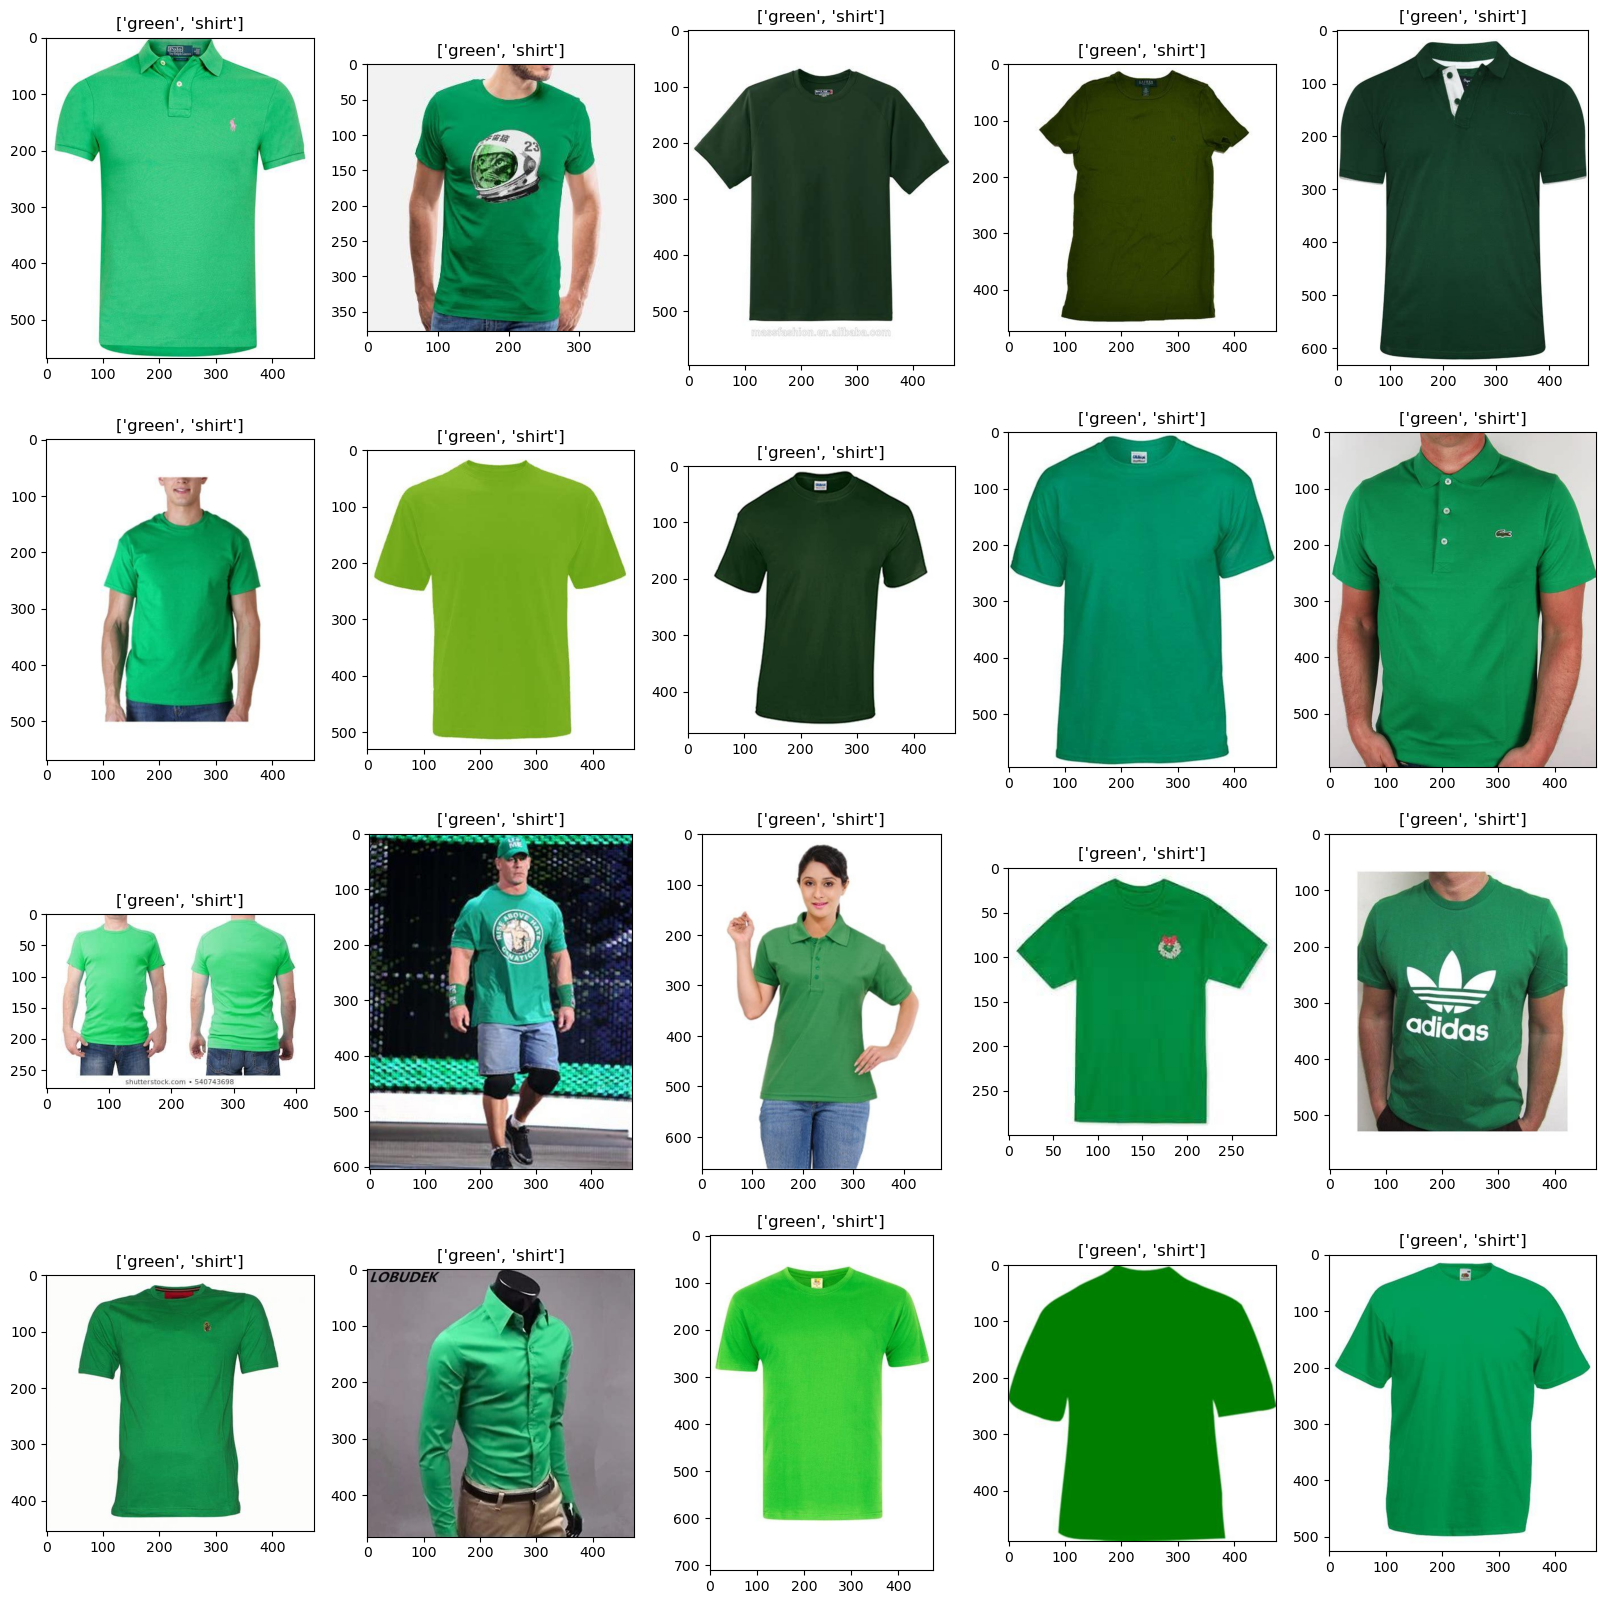

In [7]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)

    plt.imshow(sample_images[i])
    plt.title(sample_classes[i])

In [8]:
# 원하는 클래스의 이미지만 찾기

find_cls = ['white', 'shoes']

sample_classes = []
sample_images = []
sample_cnt = 0

for annot in annotations:
    cls1, cls2 = annot['classes']
    if (cls1 == find_cls[0]) and (cls2 == find_cls[1]):
        sample_classes.append(annot['classes'])
        img_path = os.path.join(data_root, annot['filepath'])
        img = Image.open(img_path).convert('RGB')
        sample_images.append(np.array(img))
        sample_cnt += 1

    if sample_cnt == 20:
        break

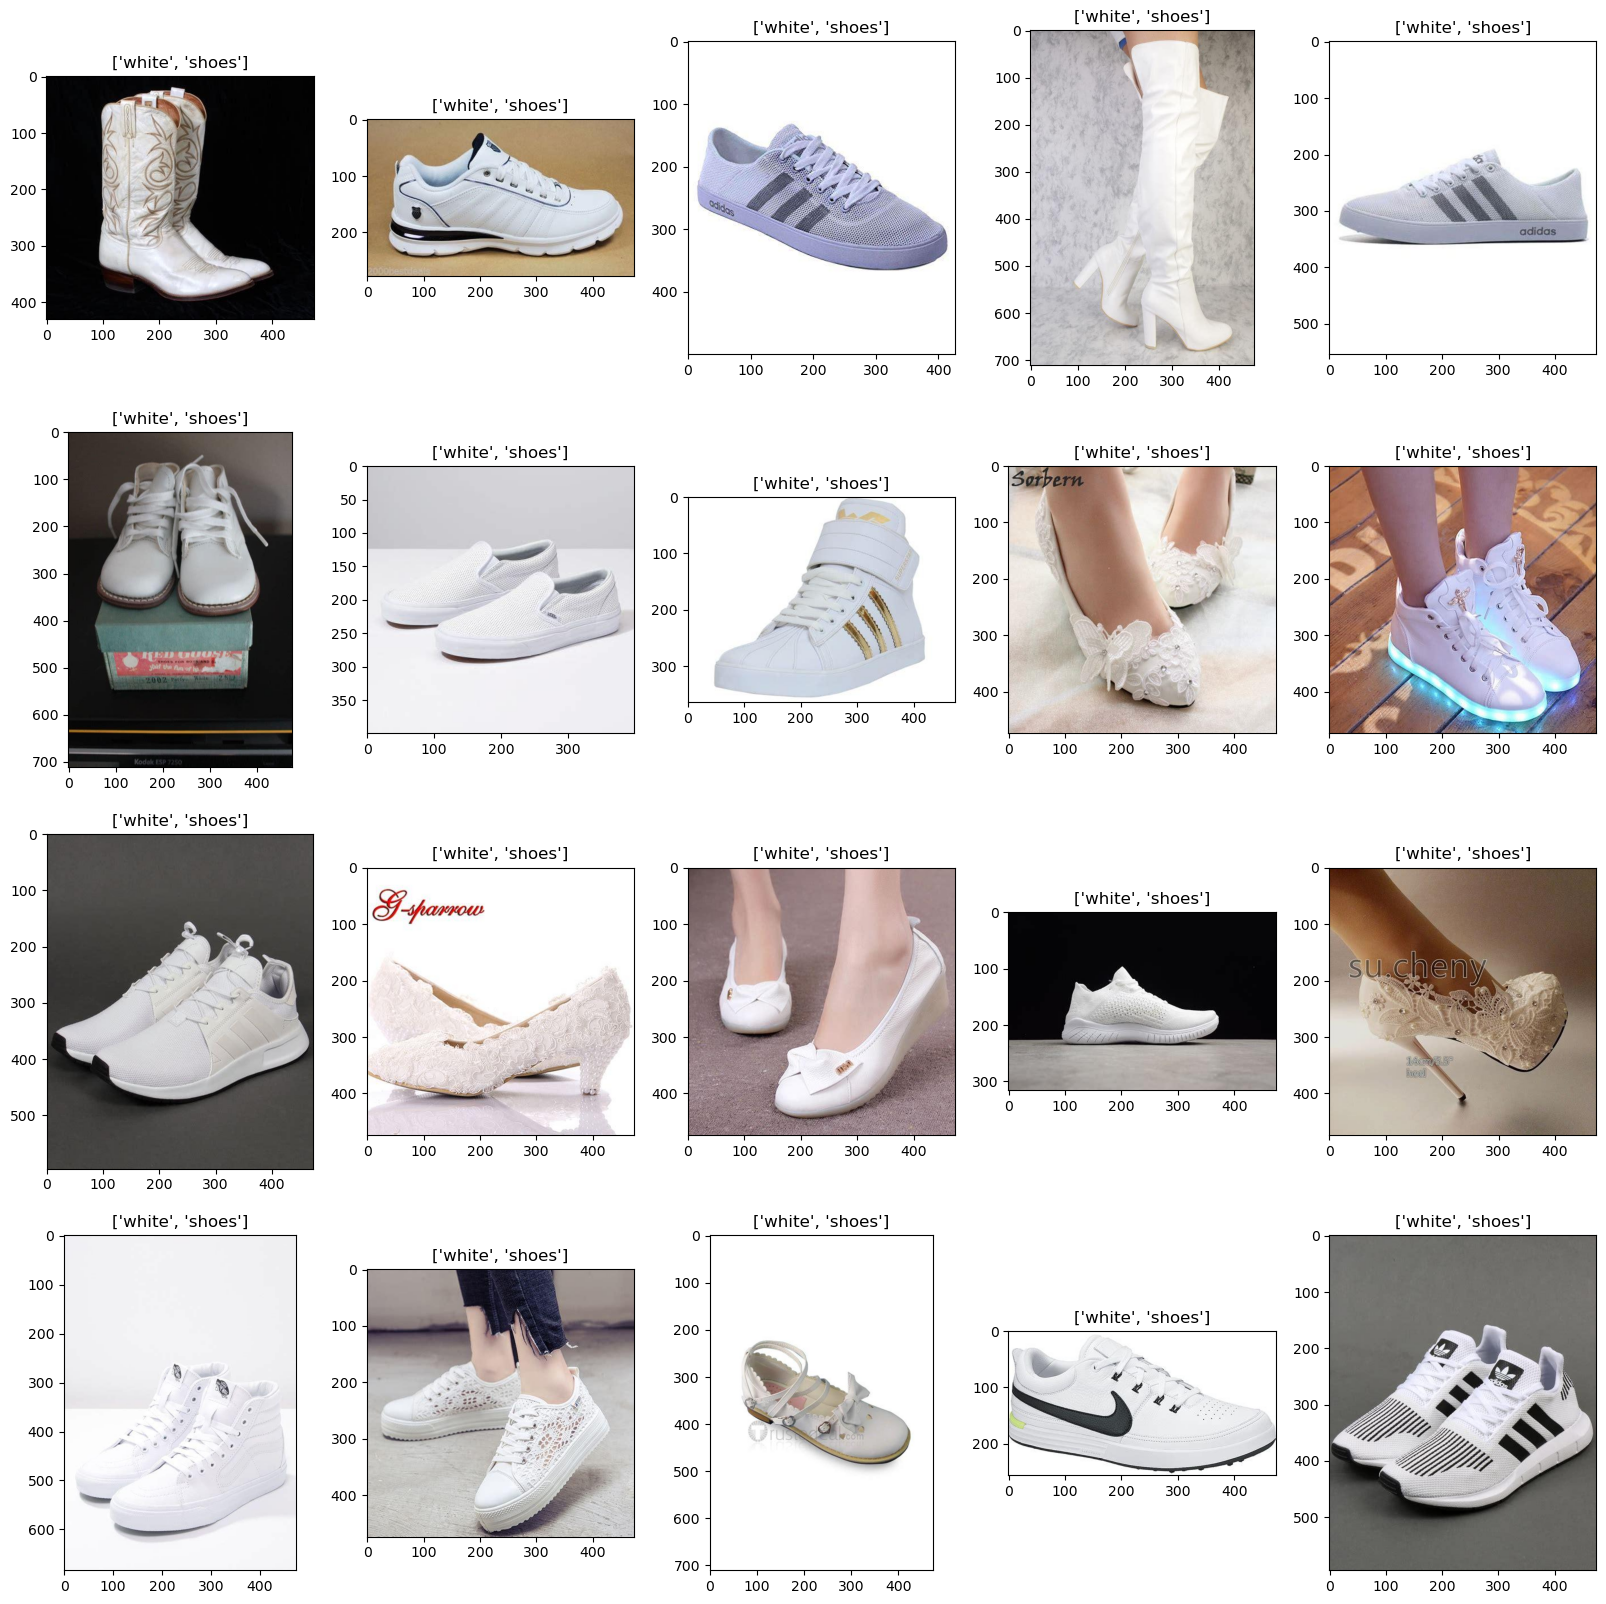

In [9]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)

    plt.imshow(sample_images[i])
    plt.title(sample_classes[i])

# Custom Dataset

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, annotations, classes, transforms):
        self.data = []
        self.data_root = data_root
        self.annotations = annotations
        self.classes = classes
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        annot = self.annotations[idx]
        image_path = os.path.join(self.data_root, annot['filepath'])
        img = Image.open(image_path).convert('RGB')
        img = self.transforms(img)

        # target은 one-hot vector로 표현한다.
        classes = annot['classes']
        targets = []
        for cls in classes:
            targets.append(self.classes.index(cls))
        targets = torch.nn.functional.one_hot(torch.tensor(targets), len(self.classes)).sum(dim=0).to(torch.float)

        return img, targets

In [11]:
# annotations를 랜덤하게 섞어준다.
random.shuffle(annotations)
annotations[:3]

[{'filepath': 'blue_pants/417129721ddaa923007cb44a4df582ae97ed07b9.jpg',
  'filename': '417129721ddaa923007cb44a4df582ae97ed07b9.jpg',
  'classes': ['blue', 'pants']},
 {'filepath': 'red_shoes/23f7ab92774f9ceca6adf99898ff1e4f5a4bc1cc.jpg',
  'filename': '23f7ab92774f9ceca6adf99898ff1e4f5a4bc1cc.jpg',
  'classes': ['red', 'shoes']},
 {'filepath': 'red_shoes/f4ffba56d79ffb6c12dd85ab1248eeee95dd9aa4.jpg',
  'filename': 'f4ffba56d79ffb6c12dd85ab1248eeee95dd9aa4.jpg',
  'classes': ['red', 'shoes']}]

In [12]:
len(annotations)

11385

In [13]:
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

total_dataset = CustomDataset(data_root, annotations[:int(len(annotations)*0.3)], classes, transforms) # 전체 데이터의 개수가 너무 많아 일부만 사용 -> 미리 랜덤하게 섞는 과정이 있었다.

In [14]:
print(classes)
total_dataset[0][1]

['green', 'shirt', 'black', 'shoes', 'red', 'dress', 'white', 'shorts', 'pants', 'blue', 'brown']


tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.])

In [15]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num+1, valid_num, test_num])

In [16]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

2733
341
341


In [17]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# model

In [18]:
model = models.vgg16(pretrained=True)
model

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
model.classifier[6] = torch.nn.Linear(4096, len(classes), bias=True)

In [20]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# train

In [21]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)

    return model, train_loss

def evaluation(model, valid_dataloader, threshold):
    model.eval()
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = torch.sigmoid(model(images))
            preds = (outputs > threshold).float()

            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

    valid_f1 = f1_score(total_labels, total_preds, average='micro')

    return model, valid_f1

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, threshold, num_epochs):
    model.to(device)
    train_loss_list = []
    valid_f1_list = []

    for epoch in range(num_epochs):
        model, train_loss = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_f1 = evaluation(model, valid_dataloader, threshold)

        print(f'Train Loss: {train_loss}, Valid F1: {valid_f1}')

        train_loss_list.append(train_loss)
        valid_f1_list.append(valid_f1)

    return model, train_loss_list, valid_f1_list

In [22]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, train_loss_list , valid_f1_list = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 0.5, 10)

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.47246499671492465, Valid F1: 0.5269343780607247


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.27302837839653327, Valid F1: 0.7058823529411765


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.20266566659475482, Valid F1: 0.8326908249807247


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.14604816533798395, Valid F1: 0.846969696969697


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.12458349716698014, Valid F1: 0.8855193328279001


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1109238819674004, Valid F1: 0.8945022288261516


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.09194340734461019, Valid F1: 0.889054355919583


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.06914371163259413, Valid F1: 0.9131403118040089


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.06121717537428404, Valid F1: 0.9131403118040089


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.06564800321059518, Valid F1: 0.900887573964497


# test

In [23]:
model.eval()
total_preds = []
total_labels = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        outputs = torch.sigmoid(model(images))
        preds = (outputs > 0.5).int()
        total_preds.extend(preds)
        total_labels.extend(labels)

  0%|          | 0/11 [00:00<?, ?it/s]

In [38]:
real_labels = torch.nonzero(total_labels[0]==1).squeeze().tolist()
real_labels

tensor([[2],
        [3]])

In [43]:
pred_labels = torch.nonzero(total_preds[2]==1).squeeze().tolist()
pred_labels

3

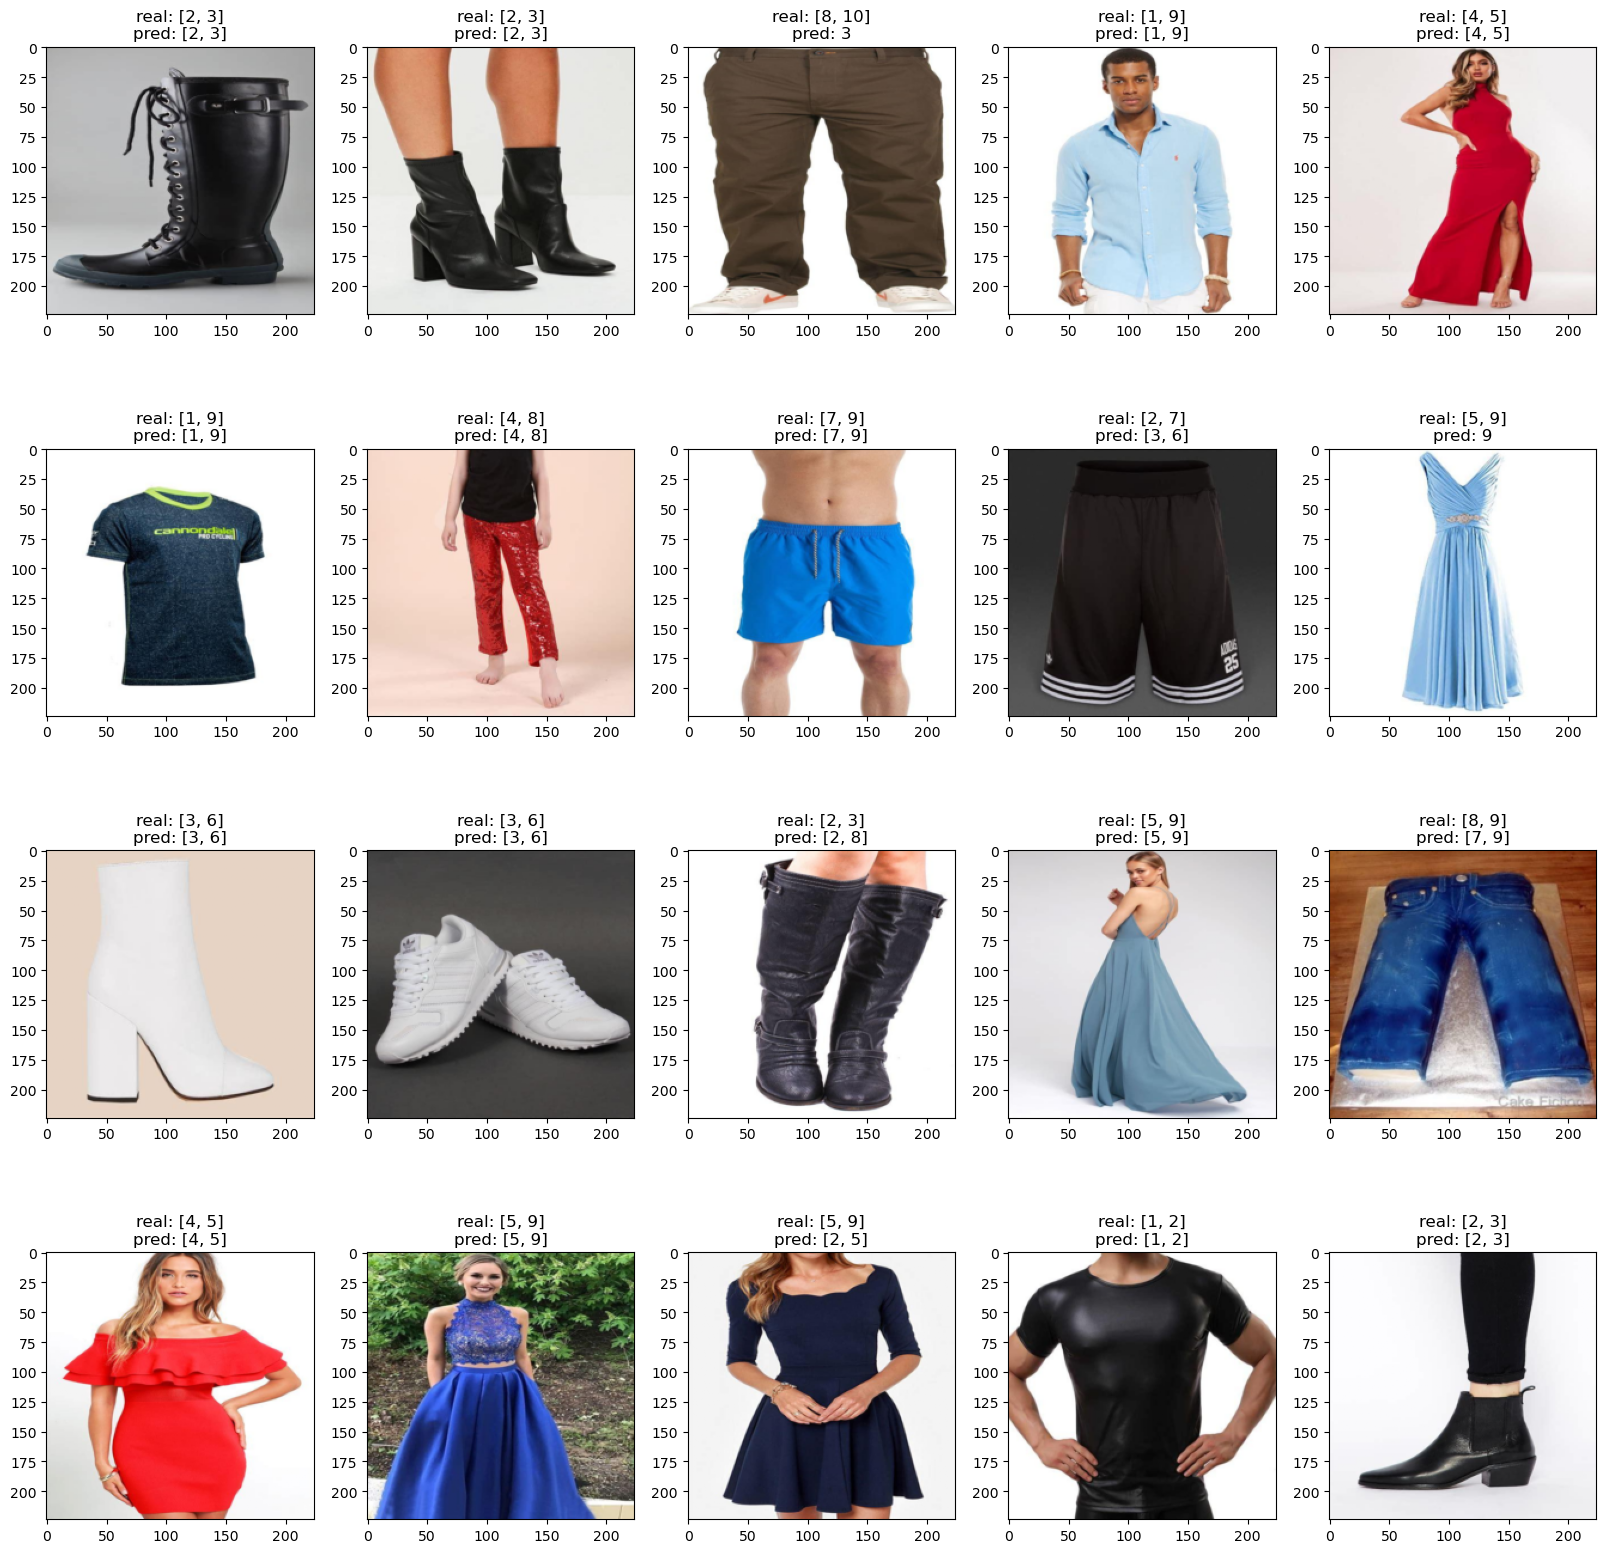

In [46]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    
    real_labels = torch.nonzero(total_labels[i]==1).squeeze().tolist()
    pred_labels = torch.nonzero(total_preds[i]==1).squeeze().tolist()
    
    plt.title(f'real: {real_labels}\npred: {pred_labels}')